In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

In [3]:
query1=''' 
    select o.id as order_id,
    o.created_at::date as order_date,
    o.email as user_id,
    o.total_line_items_price as MRP,
    o.total_discounts as discount_amount,
    total_price as total_price
    
    from orders o
    WHERE
    cancelled_at is NULL;
'''
query2=''' 
    select oli.order_id as order_id,
    oli.product_id as product_id,
    oli.name as product_name,
    oli.quantity as quantity,
    oli.price as sp
    from order_line_item oli;
'''

In [4]:
query2=''' 
    select oli.order_id as order_id,
    oli.product_id as product_id,
    oli.name as product_name,
    oli.quantity as quantity,
    oli.price as sp
    from order_line_item oli;
'''

In [5]:
o=pd.read_sql(query1,conn)
r=pd.read_sql(query2,conn)

In [6]:
data=pd.merge(o,r,on='order_id',how='left')
data['order_date']=pd.to_datetime(data['order_date'])

In [7]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel



data = data[data['order_date'] >= '2023-01-01']
data=data[data['order_date'] <= '2023/12/31']

data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()


In [8]:
data['discount_ratio'] = data['discount_amount']/data['mrp']

In [9]:
data['new_ordervalue']= data['ordervalue']-(data['ordervalue']*data['discount_ratio'])

In [10]:
totalcarts=data['order_id'].nunique()
product_level=data.groupby(['product_name']).agg(
        Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
        ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
        NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
        RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
        Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
        Total_Order_Value=pd.NamedAgg(column='new_ordervalue', aggfunc='sum'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique')
).reset_index()

In [11]:
data_new=data[data['TrxnRank']==1]

In [12]:
xuser_count = data_new.groupby(["product_name"]).agg(
    acquired_pool = pd.NamedAgg(column = "user_id", aggfunc = 'nunique'),
    x_user_list = pd.NamedAgg(column = "user_id", aggfunc = lambda x: [x.unique()])
).reset_index()

data_repeat=data[data['TrxnRank']==2]
repeat_users=data_repeat['user_id'].to_list()

l=[]
for i in range (len(xuser_count)):
    a=(xuser_count.iloc[i,2])[0]
    b=[x for x in a if x in repeat_users]
    l.append(len(b))

xuser_count['repeat_pool']=l
xuser_count['Conversion_Rate'] = xuser_count['repeat_pool']/xuser_count['acquired_pool']

conversion_result = xuser_count.copy()

In [13]:
conversion_result.drop(columns='x_user_list', inplace=True)

In [14]:
conversion_result

,product_name,acquired_pool,repeat_pool,Conversion_Rate
0,Aerolatte Steam Free Milk Frother With Stand -...,11,1,0.090909
1,Aerolatte Steam Free Milk Frother With Stand -...,1,0,0.000000
2,Aeropress Coffee Maker,8,1,0.125000
3,Aeropress Filter Paper,2,1,0.500000
4,Aeropress Go Coffee Maker,1,0,0.000000
...,...,...,...,...
508,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,190,21,0.110526
509,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,72,11,0.152778
510,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,5,1,0.200000
511,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,11,0,0.000000


In [15]:
productlevel=pd.merge(product_level,conversion_result,on='product_name', how='left')

In [16]:
productlevel

,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,Total_Order_Value,Order_Count,acquired_pool,repeat_pool,Conversion_Rate
0,Aerolatte Steam Free Milk Frother With Stand -...,14,14,1950.000000,11,3,14,0.717175,25137.626806,14,11.0,1.0,0.090909
1,Aerolatte Steam Free Milk Frother With Stand -...,2,2,2150.000000,1,1,2,0.112962,4300.000000,2,1.0,0.0,0.000000
2,Aeropress Coffee Maker,11,11,3827.272727,8,3,11,1.105974,39633.544545,11,8.0,1.0,0.125000
3,Aeropress Filter Paper,2,2,520.000000,2,0,2,0.027321,1040.000000,2,2.0,1.0,0.500000
4,Aeropress Go Coffee Maker,2,2,4450.000000,1,1,2,0.233804,8628.697404,2,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,251,263,490.000000,193,62,240,3.385436,65666.618768,251,190.0,21.0,0.110526
603,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,177,214,650.000000,72,107,158,3.654180,74121.910659,177,72.0,11.0,0.152778
604,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,11,14,1300.000000,5,6,11,0.478117,9644.270732,11,5.0,1.0,0.200000
605,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,14,14,1550.000000,11,3,14,0.570063,19989.506173,14,11.0,0.0,0.000000


In [17]:
# productlevel=pd.merge(product_level,produser_newcount, on='product_name', how='left')
# productlevel=pd.merge(productlevel,k1,on='product_name',how='left')

productlevel['NewRepeatConversionRatio']=productlevel['Conversion_Rate']
productlevel['NewRepeatConversionRatio']=productlevel['NewRepeatConversionRatio'].fillna(0)
productlevel=productlevel.sort_values('NewRepeatConversionRatio')
productlevel['CartPenetration']=productlevel['Carts']/totalcarts
productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

In [18]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels))#.astype('int64')

In [19]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels))#.astype('int64')
productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
# productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
# productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
def ProductCohortLables2(df):
    if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
        return 'Hero Products'
    elif df['NewRepeatConversion_score'] >2:
        return 'High Repeat Products'
    elif (df['CP_score'] >2):
        return 'New Business Products'
    elif (df['ASP_score'] >3):
        return 'High Value & Slow Moving Products'
    elif (df['ASP_score'] <=3):
        return 'Low Value & Slow Moving Products'
    else:
        return 'Low Value & Slow Moving Products'
productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)

In [20]:
p1=productlevel.groupby(
   'Product Cohort Lables'
).agg(
   ProductCount=pd.NamedAgg(column='product_name', aggfunc='nunique'),
   Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
   Total_Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
   Users=pd.NamedAgg(column='Users', aggfunc='sum'),
   AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
   QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
   CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='sum'),
   NewRepeatConversionRatio=pd.NamedAgg(column='NewRepeatConversionRatio', aggfunc='mean'),
   Total_Order_Value=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
   # OrderCount=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
   #  NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
   NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
   ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
   # AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
   Order_Count=pd.NamedAgg(column='Order_Count', aggfunc='sum'),
   Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
   Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

 ).reset_index()
p1=p1.sort_values('CartPenetration', ascending =False)
p1['AOVContribution']=p1['Total_Order_Value']/p1['Order_Count'].sum()
p1
p1['ProductCountMix']=p1['ProductCount']/p1['ProductCount'].sum()
p1['OrdersMix']=p1['Orders']/p1['Orders'].sum()
p1['UsersMix']=p1['Users']/p1['Users'].sum()
p1['AOVContribution(%)']=p1['AOVContribution']/p1['AOVContribution'].sum()
p1['OrderPerSKU']=p1['Orders']/p1['ProductCount']

In [21]:
p1

,Product Cohort Lables,ProductCount,Orders,Total_Quantity,Users,AverageSellingPrice,QuantityperCart,CartPenetration,NewRepeatConversionRatio,Total_Order_Value,...,ASPXQpC,Order_Count,Top10SKUs,Bottom10SKUs,AOVContribution,ProductCountMix,OrdersMix,UsersMix,AOVContribution(%),OrderPerSKU
0,Hero Products,230,33737,37808,30303,894.912829,1.124153,0.886276,0.317750,1.400930e+07,...,234638.454727,33737,[Tanzania Coffee (From Mt Kilimanjaro) - Whole...,[Single Malt Whiskey Barrel Aged Coffee - Whol...,283.721068,0.378913,0.683253,0.684520,0.667673,146.682609
4,New Business Products,73,14839,15740,13194,1096.031906,1.118144,0.389823,0.062897,5.909345e+06,...,91378.338016,14839,"[Kalita Wave Filter Paper (155/185) - 185, Aer...",[Baba Budangiri Estate Coffee - Decoction Coff...,119.678086,0.120264,0.300525,0.298042,0.281635,203.273973
3,Low Value & Slow Moving Products,133,329,357,323,937.374687,1.094450,0.008643,0.000000,2.046595e+05,...,137305.345238,329,[Honey & Caramel Blend - 250 gm / Syphon Coffe...,"[Holiday Blend Coffee - Hario V60 / 250 gm, Ho...",4.144834,0.219110,0.006663,0.007296,0.009754,2.473684
1,High Repeat Products,73,268,294,253,1982.166014,1.108317,0.007040,0.646575,4.105304e+05,...,157485.420635,268,"[Bialetti Moka Pot (3Cup - Red) - Red, Baratza...",[Baba Budangiri Estate Coffee - Whole Beans / ...,8.314202,0.120264,0.005428,0.005715,0.019566,3.671233
2,High Value & Slow Moving Products,98,204,236,196,2591.777940,1.120773,0.005359,0.000000,4.484507e+05,...,280178.220522,204,[Kalita Wave Dripper Series (Stainless Steel o...,[Tanzania Coffee (From Mt Kilimanjaro) - Cold ...,9.082178,0.161450,0.004131,0.004427,0.021373,2.081633


In [22]:
SummaryTable=p1[['Product Cohort Lables', 'ProductCount','Orders','Total_Quantity','OrdersMix',
       'UsersMix','AverageSellingPrice','NewRepeatConversionRatio',
       'CartPenetration',"QuantityperCart",'AOVContribution',
       'OrderPerSKU', 'Total_Order_Value','Order_Count']]

In [23]:
SummaryTable['ProductCount'] = SummaryTable['ProductCount'].astype('int')
SummaryTable['Orders'] = SummaryTable['Orders'].astype('int')
SummaryTable['Total_Quantity'] = SummaryTable['Total_Quantity'].astype('int')
SummaryTable['OrdersMix'] = round(SummaryTable['OrdersMix'], 2)
SummaryTable['UsersMix'] = round(SummaryTable['UsersMix'], 2)
SummaryTable['AverageSellingPrice'] = round(SummaryTable['AverageSellingPrice'], 2)
SummaryTable['NewRepeatConversionRatio'] = round(SummaryTable['NewRepeatConversionRatio'], 2)
SummaryTable['CartPenetration'] = round(SummaryTable['CartPenetration'], 3)
SummaryTable['QuantityperCart'] = round(SummaryTable['QuantityperCart'], 2)
SummaryTable['AOVContribution'] = round(SummaryTable['AOVContribution'], 2)
SummaryTable['OrderPerSKU'] = round(SummaryTable['OrderPerSKU'], 1)
SummaryTable['Total_Order_Value'] = round(SummaryTable['Total_Order_Value'], 1)
SummaryTable['Order_Count'] = SummaryTable['Order_Count'].astype('int')

In [24]:
SummaryTable

,Product Cohort Lables,ProductCount,Orders,Total_Quantity,OrdersMix,UsersMix,AverageSellingPrice,NewRepeatConversionRatio,CartPenetration,QuantityperCart,AOVContribution,OrderPerSKU,Total_Order_Value,Order_Count
0,Hero Products,230,33737,37808,0.68,0.68,894.91,0.32,0.886,1.12,283.72,146.7,14009295.2,33737
4,New Business Products,73,14839,15740,0.30,0.30,1096.03,0.06,0.390,1.12,119.68,203.3,5909344.8,14839
3,Low Value & Slow Moving Products,133,329,357,0.01,0.01,937.37,0.00,0.009,1.09,4.14,2.5,204659.5,329
1,High Repeat Products,73,268,294,0.01,0.01,1982.17,0.65,0.007,1.11,8.31,3.7,410530.4,268
2,High Value & Slow Moving Products,98,204,236,0.00,0.00,2591.78,0.00,0.005,1.12,9.08,2.1,448450.7,204


In [25]:
sum_row = ['Overall', SummaryTable['ProductCount'].sum(), SummaryTable['Orders'].sum(), SummaryTable['Total_Quantity'].sum(), SummaryTable['OrdersMix'].sum(), SummaryTable['UsersMix'].sum(), SummaryTable['AverageSellingPrice'].sum(), (SummaryTable['NewRepeatConversionRatio']*SummaryTable['ProductCount']).sum()/(SummaryTable['ProductCount'].sum()*SummaryTable['NewRepeatConversionRatio'].sum()), SummaryTable['CartPenetration'].sum(), SummaryTable['QuantityperCart'].mean(), SummaryTable['AOVContribution'].sum(), SummaryTable['OrderPerSKU'].mean(), SummaryTable['Total_Order_Value'].sum(), SummaryTable['Order_Count'].sum()]
SummaryTable.loc[len(SummaryTable)] = sum_row

In [26]:
SummaryTable

,Product Cohort Lables,ProductCount,Orders,Total_Quantity,OrdersMix,UsersMix,AverageSellingPrice,NewRepeatConversionRatio,CartPenetration,QuantityperCart,AOVContribution,OrderPerSKU,Total_Order_Value,Order_Count
0,Hero Products,230,33737,37808,0.68,0.68,894.91,0.320000,0.886,1.120,283.72,146.70,14009295.2,33737
4,New Business Products,73,14839,15740,0.30,0.30,1096.03,0.060000,0.390,1.120,119.68,203.30,5909344.8,14839
3,Low Value & Slow Moving Products,133,329,357,0.01,0.01,937.37,0.000000,0.009,1.090,4.14,2.50,204659.5,329
1,High Repeat Products,73,268,294,0.01,0.01,1982.17,0.650000,0.007,1.110,8.31,3.70,410530.4,268
2,High Value & Slow Moving Products,98,204,236,0.00,0.00,2591.78,0.000000,0.005,1.120,9.08,2.10,448450.7,204
5,Overall,607,49377,54435,1.00,1.00,7502.26,0.200621,1.297,1.112,424.93,71.66,20982280.6,49377


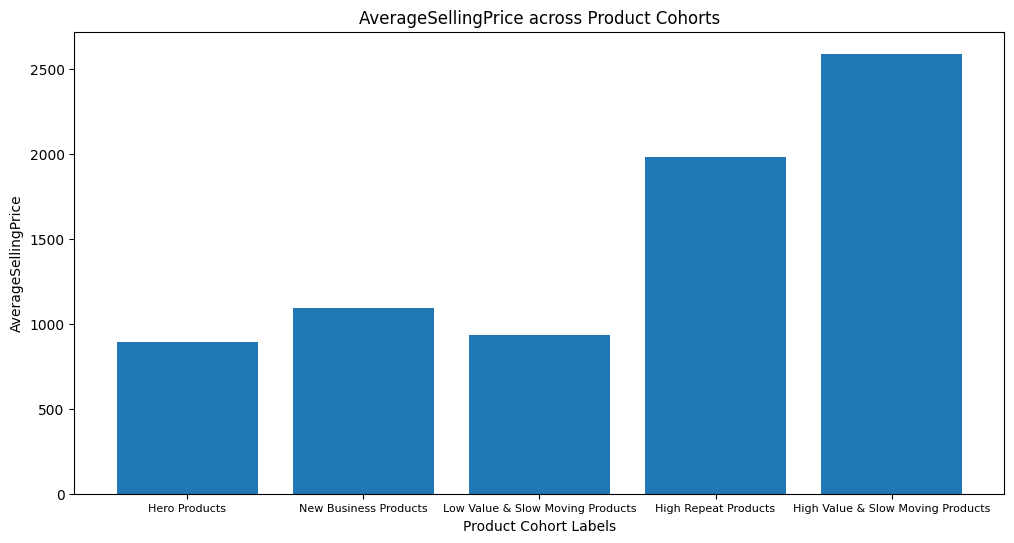

In [27]:
column_to_plot = 'AverageSellingPrice'
x_labels = p1['Product Cohort Lables']
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(x_labels, p1[column_to_plot])
plt.xlabel('Product Cohort Labels')
plt.ylabel(column_to_plot)
plt.title(f'{column_to_plot} across Product Cohorts')
plt.xticks(fontsize=8)
plt.show()

In [28]:
# #Visualization of cohorts with key parameters as axises
# fig = plt.figure(figsize = (15, 15))
# ax = plt.axes(projection ="3d")
# size=segstats['Users']*.05
# # Creating plot
# ax.scatter3D(segstats['CartPenetration'], segstats['NewUserRatio'],segstats['AverageSellingPrice'], s=size)
# plt.title("Product Cohort Distribution")
# ax.set_xlabel('CartPenetration', fontweight ='bold')
# ax.set_ylabel('NewUserRatio', fontweight ='bold')
# ax.set_zlabel('AverageSellingPrice', fontweight ='bold')
# for i in range(len(segstats)):
#      ax.text(segstats['CartPenetration'][i],
#                segstats['NewUserRatio'][i],
#              segstats['AverageSellingPrice'][i],
#                segstats['Product Cohort Lables'][i],
#                horizontalalignment='left',
#                rotation=25, wrap=True,
#                verticalalignment='center',
#                size='medium', color='black')
